Instalação e carregamento das bibliotecas de GA em python

In [86]:
!pip install deap

Instalação e carregamento das demais bibliotecas

In [87]:
import random
import math
import locale
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms
from openpyxl.utils.exceptions import InvalidFileException
from datetime import datetime

In [88]:
# Ler os arquivos Excel
df_projetos = pd.read_excel('Info_projetos_v0.xlsx')
df_contratos = pd.read_excel('Info_contratos_v0.xlsx')
df_distancias = pd.read_excel('Info_distancias_v0.xlsx')

In [89]:
# Visualização dos DataFrames
print(df_projetos.head(10))

  Projeto Tipo operação Tipo de linha Categoria linha  UEP Data prevista  \
0  Poço 1      carregam          T1_P              T1  P-1    2026-01-01   
1  Poço 1      carregam            T2              T2  P-1    2025-11-11   
2  Poço 2      carregam         T1_I1              T1  P-2    2025-12-30   
3  Poço 3      carregam          T1_G              T1  P-3    2025-07-27   
4  Poço 3      carregam          T1_P              T1  P-3    2026-02-16   
5  Poço 4   descarregam            T2              T2  P-4    2025-08-17   
6  Poço 5      carregam         T1_I1              T1  P-5    2025-07-20   
7  Poço 5      carregam            T2              T2  P-5    2025-08-08   
8  Poço 6      carregam          T1_P              T1  P-6    2026-05-07   
9  Poço 6      carregam            T2              T2  P-6    2026-03-19   

   Número de tramos Contrato bens Contrato log  
0                 8            C1           L1  
1                 2            C4           L4  
2               

In [90]:
# Visualização dos DataFrames
print(df_contratos.head(10))

  Contrato bens Contrato log Fornec Custo entrega B1 Custo entrega B2  \
0            C1           L1     F1            50000            75000   
1            C2            x     F2                x                x   
2            C3           L3     F1            37000            48000   
3            C4           L4     F6           337000           300000   
4            C5           L5     F2            18000            34000   
5            C6           L6     F4           125000           121000   
6            C7           L7     F3            17000            36000   
7            C8           L8     F1            31000            39000   
8            C9           L9     F2            20500            32000   
9           C10          L10     F5           237500           247200   

  Custo diaria carreg Categoria linha  
0               94708              T1  
1                   x              T1  
2               89132              T1  
3                   x              T

In [91]:
# Visualização dos DataFrames
print(df_distancias.head(10))

    UEP  Dist_B1_mn  Dist_B2_mn  Dist_F1_mn  Dist_F2_mn  Dist_F3_mn
0   P-1          98         130         308          99          99
1   P-2         240         340         156         241         241
2   P-3         252         342         162         253         253
3   P-4          60         110         264          61          61
4   P-5         102         136         284         103         103
5   P-6         232         331         144         233         233
6   P-7          93         122         318          94          94
7   P-8         112         143         239         113         113
8   P-9          65         122         213          66          66
9  P-10         247         349         165         248         248


In [147]:
# Função para cálculo dos custos referentes a suprimento:
# Considera os custos referentes a entrega nas bases próprias e carregamento nos fornecedores

def calcular_custo_suprim(df_projetos, df_contratos):
    """
    Adiciona quatro colunas calculadas ao df_projetos conforme especificações

    Parâmetros:
    df_projetos: DataFrame com dados dos projetos
    df_contratos: DataFrame com dados dos contratos

    Retorna:
    DataFrame df_projetos com as quatro novas colunas adicionadas
    """
    #Referências para cácludo da duração dos tempos de carregamento:
    t0 = 0.4 # parâmetro tempo fixo carregamento ou descarregamento
    x1 = 0.83 # parâmetro tempo variável carregamento T1, por tramo
    x2 = 1.57 # parâmetro tempo variável carregamento T2, por tramo
    y1 = 0.66 # parâmetro tempo variável descarregamento T1, por tramo
    y2 = 0.95 # parâmetro tempo variável descarregamento T2, por tramo

    try:
        # Verificar colunas necessárias a realização dos cálculos:
        required_proj = ['Número de tramos', 'Tipo de linha', 'Tipo operação', 'Contrato log', 'Contrato bens']
        required_cont = ['Contrato log', 'Contrato bens', 'Custo entrega B1', 'Custo entrega B2', 'Custo diaria carreg']

        for col in required_proj:
            if col not in df_projetos.columns:
                raise ValueError(f"Coluna '{col}' não encontrada em df_projetos")

        for col in required_cont:
            if col not in df_contratos.columns:
                raise ValueError(f"Coluna '{col}' não encontrada em df_contratos")

        # 1. Calcular 'Tempo carreg - dias', considerando as particularidades dos projetos:
        conditions = [
            (df_projetos['Tipo de linha'] != 'T2') & (df_projetos['Tipo operação'] == 'carregam'),
            (df_projetos['Tipo de linha'] == 'T2') & (df_projetos['Tipo operação'] == 'carregam'),
            (df_projetos['Tipo de linha'] != 'T2') & (df_projetos['Tipo operação'] == 'descarregam'),
            (df_projetos['Tipo de linha'] == 'T2') & (df_projetos['Tipo operação'] == 'descarregam')
        ]

        choices = [
            df_projetos['Número de tramos'] * x1 + t0,
            df_projetos['Número de tramos'] * x2 + t0,
            df_projetos['Número de tramos'] * y1 + t0,
            df_projetos['Número de tramos'] * y2 + t0
        ]

        df_projetos['Tempo carreg dias'] = np.select(conditions, choices, default=0)

        # Criar dicionários para relacionar contratos aos valores de referência
        dict_b1 = df_contratos.set_index('Contrato log')['Custo entrega B1'].to_dict()
        dict_b2 = df_contratos.set_index('Contrato log')['Custo entrega B2'].to_dict()
        dict_carreg = df_contratos.set_index('Contrato bens')['Custo diaria carreg'].to_dict()

        # 2. Calcular 'Custo fornec B1'
        # Ajuste dos custos para linhas sem contrato de logística
        # Ajuste da referência de coluna para cálculo do custo fornecimento B1
        df_projetos['Custo_fornec_B1'] = df_projetos.apply(
            lambda row: 0 if row['Tipo operação'] == 'descarregam'
            else 0 if (row['Contrato log'] == 'x' and row['Tipo operação'] == 'carregam')
            else int(row['Número de tramos'] * dict_b1.get(row['Contrato log'], 0)),
            axis=1
        ) # Calcula o custo de fornecimento de N tramos, considerando entrega na B1

        # 3. Calcular 'Custo fornec B2'
        df_projetos['Custo_fornec_B2'] = df_projetos.apply(
            lambda row: 0 if row['Tipo operação'] == 'descarregam'
            else 0 if (row['Contrato log'] == 'x' and row['Tipo operação'] == 'carregam')
            else int(row['Número de tramos'] * dict_b2.get(row['Contrato log'], 0)),
            axis=1
        ) # Calcula o custo de fornecimento de N tramos, considerando entrega na B2

        # 4. Calcular 'Custo carreg fornec' - Custo referente a carregamento nos fornecedores
        df_projetos['Custo_carreg_fornec'] = df_projetos.apply(
            lambda row: 90000000 if (row['Contrato log'] == 'x' or
                                  dict_carreg.get(row['Contrato bens'], 'x') == 'x')
            else int(row['Tempo carreg dias'] * dict_carreg.get(row['Contrato bens'], 0)),
            axis=1
        ) # Calcula o custo de carregamento diretamente nos fornecedores, considerando o tempo calculado acima

        #print("Colunas adicionadas com sucesso!")
        return df_projetos

    except Exception as e:
        print(f"Erro ao calcular colunas: {str(e)}") # Informa e descreve o erro gerado ao aplicar a função
        return df_projetos


In [148]:
# Aplicação da função para cálculo dos custos referentes a suprimento:

df_projetos_suprim = calcular_custo_suprim(df_projetos, df_contratos)
print(df_projetos_suprim.head(20))

    Projeto Tipo operação Tipo de linha Categoria linha   UEP Data prevista  \
0    Poço 1      carregam          T1_P              T1   P-1    2026-01-01   
1    Poço 1      carregam            T2              T2   P-1    2025-11-11   
2    Poço 2      carregam         T1_I1              T1   P-2    2025-12-30   
3    Poço 3      carregam          T1_G              T1   P-3    2025-07-27   
4    Poço 3      carregam          T1_P              T1   P-3    2026-02-16   
5    Poço 4   descarregam            T2              T2   P-4    2025-08-17   
6    Poço 5      carregam         T1_I1              T1   P-5    2025-07-20   
7    Poço 5      carregam            T2              T2   P-5    2025-08-08   
8    Poço 6      carregam          T1_P              T1   P-6    2026-05-07   
9    Poço 6      carregam            T2              T2   P-6    2026-03-19   
10   Poço 7   descarregam         T1_I1              T1   P-2    2025-11-18   
11   Poço 7   descarregam            T2             

In [149]:
# Função para cálculo do custo de navegação a partir das bases próprias (BAÇU e BAVIT) e fornecedores:
def calcular_custo_naveg(df_projetos, df_distancias, df_contratos):
    """
    Calcula três tipos de custos de navegação, calculados considerando os diferentes pontos de origem
    Considera cenários partindo de B1, B2 e fornecedores (F´s)
    """
    # Custo do diesel:
    '''Valor (em reais) referente ao consumo diário de diesel na navegação:
        Referências:
          - Consumo por dia de navegação: 30 m3
          - Custo por m3: R$ 2.500 (estimativa)
    '''
    custo_diesel=30*2500

    # Velocidade de navegação:
    velocidade=10 # velocidade = 10 nós (10 milhas nauticas por hora)

    # Custo padrão aplicado em caso de inviabilidade
    custo_padrao=90000000 # Em reais

    # Verificar colunas necessárias
    colunas_projetos = ['UEP', 'Contrato log', 'Tipo operação', 'Tipo de linha']
    colunas_dist = ['UEP', 'Dist_B1_mn', 'Dist_B2_mn',
                   'Dist_F1_mn', 'Dist_F2_mn', 'Dist_F3_mn']
    colunas_contr = ['Contrato log', 'Fornec']

    # Verificar colunas faltantes
    for df, cols, name in zip([df_projetos, df_distancias, df_contratos],
                             [colunas_projetos, colunas_dist, colunas_contr],
                             ['df_projetos', 'df_distancias', 'df_contratos']):
        faltantes = [col for col in cols if col not in df.columns]
        if faltantes:
            raise ValueError(f"Colunas faltantes em {name}: {faltantes}. Colunas disponíveis: {df.columns.tolist()}")

    # Criar cópia do dataframe
    df = df_projetos.copy()

    # Merge com distâncias e contratos
    df = pd.merge(df, df_distancias[colunas_dist], on='UEP', how='left')
    df = pd.merge(df, df_contratos[colunas_contr], on='Contrato log', how='left')

    # Função auxiliar para cálculo padrão
    def calcular_custo(distancia):
        return int(((distancia / velocidade) / 24) * custo_diesel) # Valores sem casas decimais

    # Calcular custos BACU e BAVIT
    df['Custo_Naveg_B1'] = df['Dist_B1_mn'].apply(calcular_custo)
    df['Custo_Naveg_B2'] = df['Dist_B2_mn'].apply(calcular_custo)

    # Calcular custo por fornecedor
    def custo_fornecedor(row):
        # Verificar condições para usar custo padrão
        if (row['Tipo operação'] == 'descarregam' or
            row['Tipo de linha'] == 'T2' or
            row['Contrato log'] == 'x'):
            return int(custo_padrao) # Valores sem casas decimais

        # Caso contrário, verificar fornecedor
        if row['Fornec'] == 'F1':
            return calcular_custo(row['Dist_F1_mn'])
        elif row['Fornec'] == 'F2':
            return calcular_custo(row['Dist_F2_mn'])
        elif row['Fornec'] == 'F3':
            return calcular_custo(row['Dist_F3_mn'])
        else:
            return custo_padrao # Valores sem casas decimais

    df['Custo_Naveg_Fornec'] = df.apply(custo_fornecedor, axis=1)

    # Remover colunas temporárias
    colunas_remover = colunas_dist[1:] + ['Fornec']  # Todas colunas de distância + 'Fornec'
    df = df.drop([col for col in colunas_remover if col in df.columns], axis=1)

    return df

In [150]:
# Aplicação da função para cálculo dos custos de navegação a partir das bases e fornecedores:
df_projetos_com_custos = calcular_custo_naveg(
    df_projetos=df_projetos_suprim,
    df_distancias=df_distancias,
    df_contratos=df_contratos
)
print(df_projetos_com_custos.head(20))

    Projeto Tipo operação Tipo de linha Categoria linha   UEP Data prevista  \
0    Poço 1      carregam          T1_P              T1   P-1    2026-01-01   
1    Poço 1      carregam            T2              T2   P-1    2025-11-11   
2    Poço 2      carregam         T1_I1              T1   P-2    2025-12-30   
3    Poço 3      carregam          T1_G              T1   P-3    2025-07-27   
4    Poço 3      carregam          T1_P              T1   P-3    2026-02-16   
5    Poço 4   descarregam            T2              T2   P-4    2025-08-17   
6    Poço 5      carregam         T1_I1              T1   P-5    2025-07-20   
7    Poço 5      carregam            T2              T2   P-5    2025-08-08   
8    Poço 6      carregam          T1_P              T1   P-6    2026-05-07   
9    Poço 6      carregam            T2              T2   P-6    2026-03-19   
10   Poço 7   descarregam         T1_I1              T1   P-2    2025-11-18   
11   Poço 7   descarregam            T2             

In [151]:
# Criação de novo dataframe com colunas referentes aos custos de suprimento:
colunas_suprim = ['Custo_fornec_B1', 'Custo_fornec_B2', 'Custo_carreg_fornec']
df_suprim = df_projetos_com_custos[colunas_suprim].copy()
print(df_suprim.head(20))

    Custo_fornec_B1  Custo_fornec_B2  Custo_carreg_fornec
0            400000           600000               666744
1            674000           600000             90000000
2                 0                0             90000000
3            126000           238000               525421
4             31000            39000               172843
5                 0                0             90000000
6                 0                0             90000000
7            250000           242000             90000000
8            200000           300000               352313
9            250000           242000             90000000
10                0                0             90000000
11                0                0             90000000
12           150000           225000               273706
13           296000           384000               627489
14            20500            32000               145360
15                0                0             90000000
16            

In [152]:
# Criação de novo dataframe com colunas referentes aos custos de distribuição:
colunas_distrib = ['Custo_Naveg_B1', 'Custo_Naveg_B2', 'Custo_Naveg_Fornec']
df_distrib = df_projetos_com_custos[colunas_distrib].copy()
print(df_distrib.head(20))

    Custo_Naveg_B1  Custo_Naveg_B2  Custo_Naveg_Fornec
0            30625           40625               96250
1            30625           40625            90000000
2            75000          106250            90000000
3            78750          106875               79062
4            78750          106875               50624
5            18750           34375            90000000
6            31875           42500            90000000
7            31875           42500            90000000
8            72500          103437               45000
9            72500          103437            90000000
10           75000          106250            90000000
11           75000          106250            90000000
12           29062           38125               99375
13           35000           44687               74687
14           35000           44687               35312
15           20312           38125            90000000
16           20312           38125            90000000
17        

In [153]:
# Função objetivo: Cálculo do custo total obtido a partir da cromossomo individual

def calcular_custo_total(individual):
    """
    Ajusta o tamanho do cromossomo e calcula o custo total usando matrizes de custo pré-carregadas de arquivos Excel.

    Entrada:
    individual: lista/array com valores inteiros entre 1 e 3
    """
    # Ajuste do cromossomo binário (redimensiona o array):
      # Define que o tamanho do cromossomo deve ser igual ao número de linhas da matriz com informações dos projetos
    linhas = df_projetos_com_custos.shape[0] # Ajustar nome da matriz projetos pelo nome da matriz com info projetos

    individual = np.resize(individual, linhas)

    # Verificação de compatibilidade de tamanhos
    x = len(individual)
    if x != len(df_projetos_com_custos):
        raise ValueError(
            f"Dimensões incompatíveis: Vetor ({x} posições) × "
            f"Matriz1 ({len(df_projetos_com_custos)} linhas)"
        )

    # Cálculo do custo total
    custo_total = 0
    for i in range(len(individual)):
        if individual[i] == 1:
            custo_total += df_suprim.iloc[i, 0] + df_distrib.iloc[i, 0]  # considera valor da 1ª coluna
        elif individual[i] == 2:
            custo_total += df_suprim.iloc[i, 1] + df_distrib.iloc[i, 1]  # considera valor da 2ª coluna
        elif individual[i] == 3:
            custo_total += df_suprim.iloc[i, 2] + df_distrib.iloc[i, 2]  # considera valor da 3ª coluna
    return custo_total, #configuração como tupla, para ficar simular ao modelo (Telecom Parte B)


In [154]:
# Avaliação da F.O com cromossomo dado por uma lista com valores iguais a 1, 2 ou 3
# Obs: Deve possuir o mesmo tamanho do dataframe "df_projetos_com_custos"

individual = [random.randint(1, 3) for _ in range(len(df_projetos_com_custos))]
print(individual)


[2, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 3, 2, 3, 2, 2, 3, 1, 1, 1, 2, 2, 2, 1]


In [155]:
#Teste da função objetivo com o cromossomo gerado no passo anterior:
valor = calcular_custo_total(individual)[0]
# print(valor)
print(f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

R$ 727.917.174,00


In [156]:
# Função para definição da matriz de duração e períodos de referência a partir da matriz com informações de projeto:

def adicionar_ano_mes(df, coluna_data='data'):
    """
    Adiciona colunas de ano e mês a partir da coluna de data.

    """
    # Cria cópia para evitar modificações no DataFrame original
    df = df.copy()

    # Converte para datetime se necessário
    if not pd.api.types.is_datetime64_any_dtype(df[coluna_data]):
        df[coluna_data] = pd.to_datetime(df[coluna_data])

    # Extrai ano e mês
    df['ano'] = df[coluna_data].dt.year
    df['mes'] = df[coluna_data].dt.month

    return df

In [157]:
df_mes_ano = adicionar_ano_mes(df_projetos_com_custos, coluna_data='Data prevista')
print(df_mes_ano.head(20))

    Projeto Tipo operação Tipo de linha Categoria linha   UEP Data prevista  \
0    Poço 1      carregam          T1_P              T1   P-1    2026-01-01   
1    Poço 1      carregam            T2              T2   P-1    2025-11-11   
2    Poço 2      carregam         T1_I1              T1   P-2    2025-12-30   
3    Poço 3      carregam          T1_G              T1   P-3    2025-07-27   
4    Poço 3      carregam          T1_P              T1   P-3    2026-02-16   
5    Poço 4   descarregam            T2              T2   P-4    2025-08-17   
6    Poço 5      carregam         T1_I1              T1   P-5    2025-07-20   
7    Poço 5      carregam            T2              T2   P-5    2025-08-08   
8    Poço 6      carregam          T1_P              T1   P-6    2026-05-07   
9    Poço 6      carregam            T2              T2   P-6    2026-03-19   
10   Poço 7   descarregam         T1_I1              T1   P-2    2025-11-18   
11   Poço 7   descarregam            T2             

In [158]:
# Função restritiva - considera como restrição o tempo de carregamento disponível nos dois complexos portuários e nos fornecedores
def verificar_capacidades_com_sublocais(individual):
    """
    Verifica se todas as capacidades são atendidas, considerando que:
    - Localidades 1 e 2: corresponde as bases contratadas (modelo de disponibilidade)
    - Localidade 3 = divide-se em 6 sublocais, conforme coluna 'Fornec' em df_contratos
    - Apenas 3 sublocais possuem viabilidade de carregamento: F1, F2 e F3.

    Modelo retorna:
        True se todas as restrições de capacidade forem respeitadas, False caso contrário.
    """

    # 1. Definir os DataFrames internamente
    df_contratos_novo = df_contratos.copy()
    df_mes_ano_novo = df_mes_ano.copy()

    # 2. Juntar informações de sublocais
    df_sublocais = df_contratos_novo[['Contrato bens', 'Fornec']].drop_duplicates()
    df_full = pd.merge(df_mes_ano_novo, df_sublocais, on='Contrato bens', how='left')

    # 3. Mapear localidades (convertendo 3 para sublocais 3_F1, 3_F2, 3_F3)
    df_full['localidade_final'] = df_full.apply(
        lambda x: f"3_{x['Fornec']}" if x.name < len(individual) and individual[x.name] == 3
        else individual[x.name] if x.name < len(individual) else pd.NA,
        axis=1
    )

    # 4. Definir capacidades
    CAPACIDADES = {
        1: 30,    # Localidade 1
        2: 30,    # Localidade 2
        "3_F1": 15,  # Sublocal Fornec 1
        "3_F2": 15,  # Sublocal Fornec 2
        "3_F3": 15,  # Sublocal Fornec 3
        "3_F6": 0,  # Sublocal Fornec 6 - não carrega
        "3_F5": 0,  # Sublocal Fornec 5 - não carrega
        "3_F4": 0  # Sublocal Fornec 4 - não carrega
    }

    # 5. Agrupar e somar durações
    df_consolidado = df_full.groupby(
        ['localidade_final', 'ano', 'mes']
    )['Tempo carreg dias'].sum().reset_index()

    # 6. Verificar capacidade
    df_consolidado['capacidade'] = df_consolidado['localidade_final'].map(CAPACIDADES)
    df_consolidado['dentro_capacidade'] = (
        df_consolidado['Tempo carreg dias'] <= df_consolidado['capacidade']
    )

    # 7. Retornar True apenas se TODOS estiverem dentro da capacidade
    return all(df_consolidado['dentro_capacidade'])#, df_consolidado

In [160]:
# Teste do cromossomo gerado aleatoriamente:
teste_3 = verificar_capacidades_com_sublocais(individual)
print(teste_3)

False


Função para criação de indivíduos:

In [163]:
# Função para forçar viabilidade das operações de descarregam e carregam de linhas T2, designando as bases 1 ou 2
'''
Objetiva representar a restrição operacional de que apenas linhas carregamento de linhas T1 podem ser realizadas em forneedores
Todas as operações de descarregamento (tanto de T1 quanto de T2) e carregamento de T2 devem ser realizadas em B1 ou B2
'''
# Equivalente a aplicação de restrições de viabilidade
def GeradorDeIndividuos(icls, attr_bool_function, df = df_projetos_com_custos):
    individual = []
    for _, row in df.iterrows():
        op_type = row["Tipo operação"]
        linha_type = row["Tipo de linha"]

        # Verifica se é uma operação com restrição (local 3 inviável)
        if (op_type == "descarregam") or (op_type == "carregam" and linha_type == "T2"):
            gene = np.random.choice([1, 2])  # Só pode ser 1 ou 2
        else:
            gene = np.random.choice([1, 2, 3])  # Pode ser 1, 2 ou 3
        individual.append(gene)
    return icls(individual)

Declaração dos pacotes referentes a biblioteca do GA:

In [164]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Aplicação do algoritmo genético - (-1 para minimizar)
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [165]:
# Criando o toolbox

toolbox = base.Toolbox()

# Criação do toolbox e registro de funções iniciais
toolbox.register("attr_bool", random.randint, 1, 3)
toolbox.register("individual", GeradorDeIndividuos, creator.Individual, toolbox.attr_bool)

Criação de função de cruzamento customizada:

In [166]:
# Função de crossover com verificação de restrições
def CrossoverFunction(ind1, ind2, icls, attr_bool_function):
    # Crossover uniforme (pode substituir por outro método)
    new_ind1, new_ind2 = tools.cxTwoPoint(ind1, ind2)
    for i in range(len(ind1)):
        if random.random() < 0.5:
            new_ind1[i], new_ind2[i] = ind2[i], ind1[i]

    # Verifica restrições nos filhos
    if not verificar_capacidades_com_sublocais(ind1):
        new_ind1 = GeradorDeIndividuos(icls, attr_bool_function)
    if not verificar_capacidades_com_sublocais(ind2):
        new_ind2 = GeradorDeIndividuos(icls, attr_bool_function)

    return new_ind1, new_ind2

Criação de função de mutação customizada:

In [167]:
# Função de mutação com verificação de restrições
def mutacao(individuo, indpb, icls=creator.Individual, attr_bool_function=toolbox.attr_bool):
    # Cria uma cópia do indivíduo para mutação
    mutante = toolbox.clone(individuo)

    # Aplica a mutação padrão
    for i in range(len(mutante)):
        if random.random() < indpb:
            mutante[i] = np.random.choice([1, 2, 3])

    # Verifica as restrições
    if not verificar_capacidades_com_sublocais(mutante):
        # Se não atender, gera um novo indivíduo válido
        mutante = GeradorDeIndividuos(icls, attr_bool_function)

    return mutante,

In [169]:
# Registro das demais funções no toolbox (faz referencia as funções customizadas)
#toolbox.register("attr_bool", random.randint, 1, 3)
#toolbox.register("individual", GeradorDeIndividuos, creator.Individual, toolbox.attr_bool)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", CrossoverFunction, icls=creator.Individual, attr_bool_function=toolbox.attr_bool)
toolbox.register("mutate", mutacao, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", calcular_custo_total)

In [170]:
# Configuração do algoritmo
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

In [171]:
# Execução do algoritmo genético
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=100,
                              stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg       	min        	max       
0  	50    	1.2802e+08	8.16637e+06	3.6976e+08
1  	41    	6.28681e+07	7.94213e+06	3.70004e+08
2  	43    	4.09732e+07	7.6454e+06 	3.6942e+08 
3  	37    	2.63151e+07	7.59227e+06	3.69731e+08
4  	33    	2.25093e+07	7.33532e+06	1.89989e+08
5  	38    	2.59111e+07	7.18376e+06	3.69568e+08
6  	42    	2.95966e+07	7.09464e+06	3.68855e+08
7  	44    	3.30958e+07	7.09464e+06	3.69435e+08
8  	42    	1.85197e+07	7.07171e+06	3.68954e+08
9  	45    	1.46459e+07	7.07171e+06	1.88541e+08
10 	34    	3.27418e+07	7.0634e+06 	3.69543e+08
11 	47    	1.46775e+07	7.04452e+06	1.89804e+08
12 	43    	3.27011e+07	7.04452e+06	3.68856e+08
13 	41    	2.53246e+07	7.00388e+06	3.68251e+08
14 	38    	2.53515e+07	6.99858e+06	3.69667e+08
15 	37    	2.18482e+07	7.01202e+06	3.68552e+08
16 	36    	1.08773e+07	6.98077e+06	1.88279e+08
17 	32    	4.70188e+07	6.98077e+06	3.69849e+08
18 	30    	2.15909e+07	6.98077e+06	3.68775e+08
19 	40    	2.16897e+07	6.94952e+06	3.68669e+08
20 	41    	3.6101

In [174]:
# Melhor solução
print("\nMelhor Indivíduo:")
print([int(i) for i in hof[0]]) # identificação da melhor solução
print()

# Verificação da função de restrição
print("Atende às restrições?")
print(verificar_capacidades_com_sublocais(hof[0]))
print()

# Melhor resultado da função objetivo
melhor_custo = calcular_custo_total(hof[0])[0]
print("Melhor Resultado da Função Objetivo:")
print(f"R$ {melhor_custo:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))


Melhor Indivíduo:
[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]

Atende às restrições?
True

Melhor Resultado da Função Objetivo:
R$ 6.826.057,00


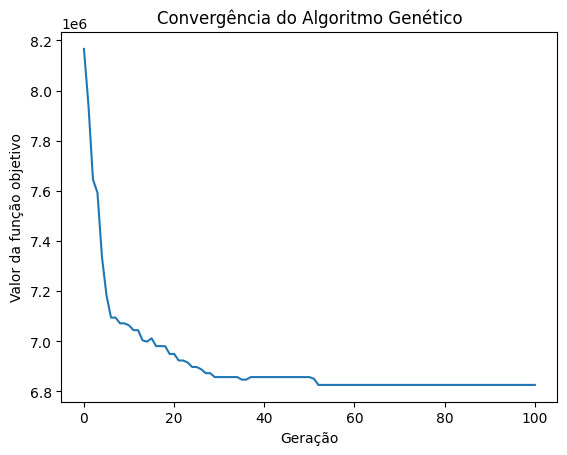

In [175]:
# Verificação de convergência do modelo
import matplotlib.pyplot as plt
gen, minVal = log.select("gen", "min")
plt.plot(gen, minVal)
plt.xlabel('Geração')
plt.ylabel('Valor da função objetivo')
plt.title('Convergência do Algoritmo Genético')
plt.show()

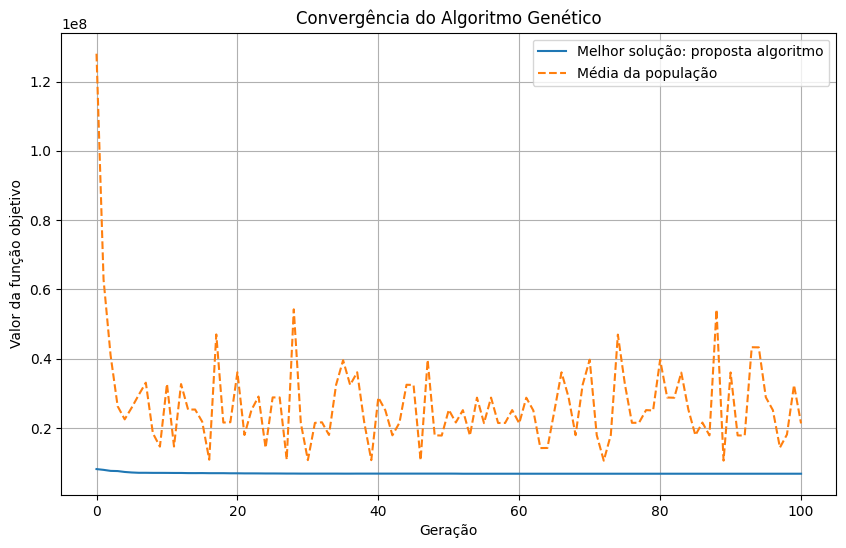

In [176]:
# Convergência do modelo x valores médios observados em cada geração:
gen, minVal = log.select("gen", "min")
_, avgVal = log.select("gen", "avg")  # Extrai os valores médios

# Cria o gráfico
plt.figure(figsize=(10, 6))
plt.plot(gen, minVal, label='Melhor solução: proposta algoritmo')
plt.plot(gen, avgVal, label='Média da população', linestyle='--')

# Configurações do gráfico
plt.xlabel('Geração')
plt.ylabel('Valor da função objetivo')
plt.title('Convergência do Algoritmo Genético')
plt.legend()
plt.grid(True)

plt.show()